In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
x = np.linspace(0,100,501)
# x

In [3]:
y = np.sin(x)
# y

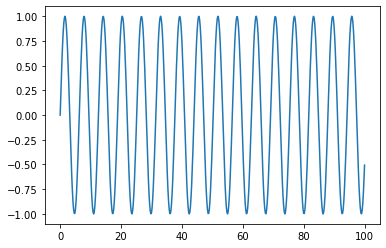

In [4]:
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data=y, index=x, columns=['sine'])
df.head()

,sine
0.0,0.000000
0.2,0.198669
0.4,0.389418
0.6,0.564642
0.8,0.717356


In [6]:
print(len(df))

501


In [7]:
# Percentage of data for testing
test_percent = 0.1

# No. of test points
test_points= np.round(len(df)*test_percent)

# Test Cut off point (index value)
test_ind = int(len(df)-test_points)

print(test_percent, test_points, test_ind)

0.1 50.0 451


In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
print(train.shape, test.shape)
print(type(train), type(test))

(451, 1) (50, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [11]:
print(scaled_train.shape, scaled_test.shape)
print(type(scaled_train), type(scaled_test))

(451, 1) (50, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = 50
# Number of timeseries samples in each batch
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

In [14]:
print(len(scaled_train),len(generator))
len(scaled_train)-len(generator) # lenght given by us

451 401


50

In [15]:
X, y = generator[0]

In [16]:
print(X.shape, y.shape)

(1, 50, 1) (1, 1)


In [17]:
# (1, 25, 1) --> (batch_size, length, n_features)

In [18]:
n_features = 1

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional

In [20]:
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(length,n_features))) # input_shape=(50,1)
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\3367823435.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5)


401/401 [==============================] - 2s 3ms/step - loss: 0.0123
Epoch 2/5
401/401 [==============================] - 1s 3ms/step - loss: 3.8461e-04
Epoch 3/5
401/401 [==============================] - 1s 3ms/step - loss: 6.4974e-04
Epoch 4/5
401/401 [==============================] - 1s 3ms/step - loss: 3.3749e-05
Epoch 5/5
401/401 [==============================] - 1s 3ms/step - loss: 9.4820e-04


<AxesSubplot:>

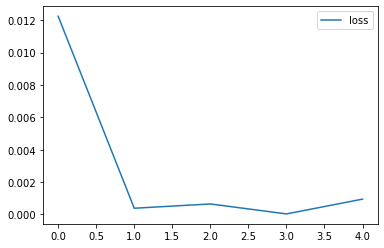

In [22]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [23]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 13ms/step


In [24]:
len(test_pred)

50

In [25]:
true_pred = scaler.inverse_transform(test_pred)

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\588475128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RNN'] = true_pred


<AxesSubplot:>

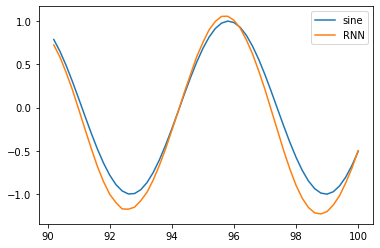

In [26]:
test['RNN'] = true_pred
test.plot()

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [29]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = 49
# Number of timeseries samples in each batch
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

val_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=1)

In [30]:
model = Sequential()
model.add(LSTM(units=49, input_shape=(length,n_features))) # input_shape=(49,1)
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 49)                9996      
                                                                 
 dense_1 (Dense)             (None, 1)                 50        
                                                                 
Total params: 10,046
Trainable params: 10,046
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


402/402 [==============================] - 4s 8ms/step - loss: 0.0283 - val_loss: 4.8658e-05


In [32]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 14ms/step


In [33]:
len(test_pred)

50

In [34]:
true_pred = scaler.inverse_transform(test_pred)

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\2336931682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM'] = true_pred


<AxesSubplot:>

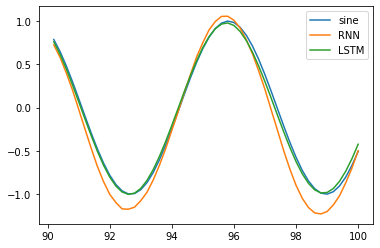

In [35]:
test['LSTM'] = true_pred
test.plot()

In [41]:
# define stacked LSTM model
model_stacked = Sequential()
model_stacked.add(Bidirectional(LSTM(49, activation='relu'), input_shape=(length, n_features)))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 49)                9996      
                                                                 
 dense_1 (Dense)             (None, 1)                 50        
                                                                 
Total params: 10,046
Trainable params: 10,046
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

 17/402 [>.............................] - ETA: 2s - loss: 1.8210e-05

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


402/402 [==============================] - 3s 7ms/step - loss: 6.1421e-04 - val_loss: 1.2032e-06


In [43]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 13ms/step


In [44]:
len(test_pred)

50

In [45]:
true_pred = scaler.inverse_transform(test_pred)

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_12844\3618196425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Bi-LSTM'] = true_pred


<AxesSubplot:>

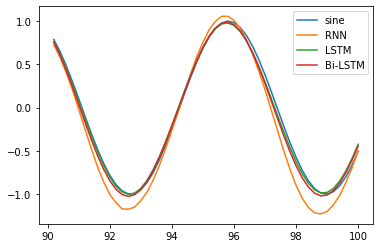

In [46]:
test['Bi-LSTM'] = true_pred
test.plot()

In [47]:
def regression_error (y_test, y_pred):
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    MAE = mean_absolute_error(y_test,y_pred)
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    
    print(f"MAE: {MAE}")
    print(f"MSE: {MSE}")
    print(f"RMSE: {RMSE}")
    print(f"r2: {r2}")

In [49]:
regression_error(test['sine'],test['RNN'])
print('\n')
regression_error(test['sine'],test['LSTM'])
print('\n')
regression_error(test['sine'],test['Bi-LSTM'])

MAE: 0.13326005442877842
MSE: 0.026159690596706465
RMSE: 0.1617395764700355
r2: 0.944977985056234


MAE: 0.0364758312705305
MSE: 0.0018515490151106827
RMSE: 0.04302962950236363
r2: 0.99610561305372


MAE: 0.0471735889490828
MSE: 0.0032398526959253548
RMSE: 0.05691970393392217
r2: 0.9931855759993871
